In [547]:
import math
import random
from graphviz import Digraph

In [548]:
class Value:
    def __init__(self, data, children=(), operation='', label=''):
        self.data = data
        self.label = label
        self.prev = children
        self.operation = operation
        self.grad = 0.0
        self.backward = lambda : None

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out.backward = _backward
        return out

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out.backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out.backward = _backward

        return out

    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return self * -1
    
    def tanh(self):
        out = Value(math.tanh(self.data), (self, ), 'tanh')

        def _backward():
            self.grad += (1 - math.tanh(self.data)**2) * out.grad
        out.backward = _backward

        return out
    
    def top_backward(self):
        self.grad = 1.0

        def backward_recursion(parent_node):
            parent_node.backward()
            for node in parent_node.prev:
                backward_recursion(node)
        
        backward_recursion(self)


In [549]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n.operation:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.operation, label = n.operation)
      # and connect this node to it
      dot.edge(uid + n.operation, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.operation)

  return dot

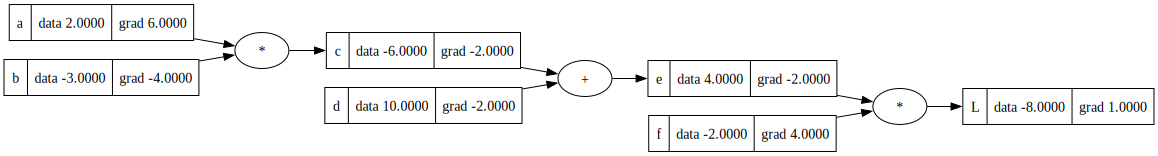

In [550]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
d = Value (10.0, label='d')
f = Value (-2.0, label='f')

c = a * b; c.label='c'
e = c + d; e.label='e'
L = e * f; L.label='L'
L.top_backward()
draw_dot(L)

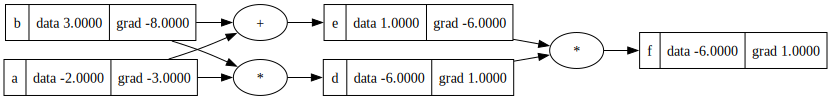

In [551]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.top_backward()

draw_dot(f)

In [552]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.top_backward()

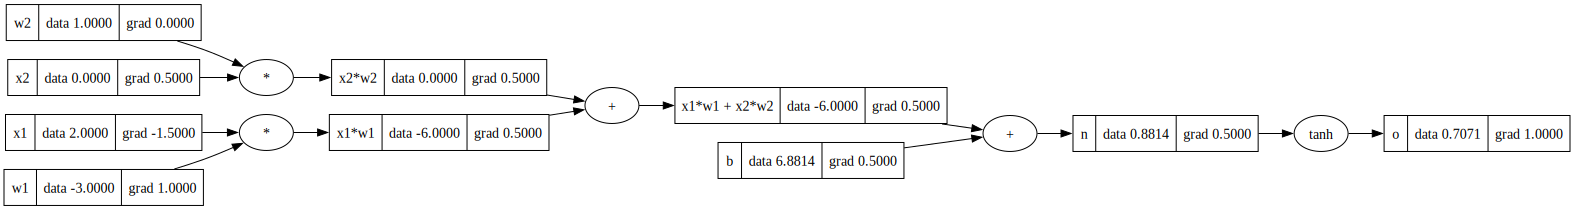

In [553]:
draw_dot(o)

In [554]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        activation = sum( xi*wi for xi, wi in zip(x, self.w)) + self.b
        return activation.tanh()
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
    
    def parameters(self):
        return [parameters for neuron in self.neurons for parameters in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        mlp = [nin] + nouts
        self.layers = [Layer(mlp[n], mlp[n+1]) for n in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [parameters for layer in self.layers for parameters in layer.parameters()]

In [555]:
nn = MLP(2, [3, 1])

In [556]:
def describe_mlp(nn):
    for i, layer in enumerate(nn.layers):
        print('layer: ', i + 1)
        for ni, neuron in enumerate(layer.neurons):
            print('neuron', ni + 1)
            for wi, w in enumerate(neuron.w):
                print(f'w{wi + 1}: {w.data}')
            print(f'b: {neuron.b.data}')
        print('')

In [557]:
describe_mlp(nn)

layer:  1
neuron 1
w1: -0.18456009177454757
w2: -0.4620518000755711
b: -0.5431172187905224
neuron 2
w1: 0.9149793541336517
w2: 0.4579966484910789
b: -0.6302753412879081
neuron 3
w1: 0.05303638215062989
w2: -0.3936397056852259
b: 0.1302115216537545

layer:  2
neuron 1
w1: 0.26176827139543435
w2: -0.5812452290657768
w3: 0.384222144098737
b: -0.28604104919102324



In [582]:
inputs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
]
desired_outputs = [1.0, -1.0, -1.0, 1.0]


In [584]:
for i in range(20):
    predicted_values = [nn(x) for x in inputs]
    print(predicted_values)

    loss = sum([(predicted-desired)**2 for desired, predicted in zip(desired_outputs, predicted_values)])
    print(loss)

    for p in nn.parameters():
        p.grad = 0
    loss.top_backward()

[Value(data=-0.8854405190232227), Value(data=-0.6323870387219481), Value(data=-0.6328347618759652), Value(data=-0.7396643493845909)]
Value(data=6.851267600680568)
